# Tarea 1: Introducción a los estimadores de Error A posteriori
#### Nombre: Ignacio Ruminot Aburto - iruminot@udec.cl

#### Problema 3. (Parte Computacional)
Considere el problema de convección-difusión undimensional $(\nu > 0)$
$$
 \begin{aligned}
-\nu u^{\prime \prime} (x) + \beta u^{\prime} (x) &= 1, \quad x \in \Omega:= (0,1) \\
u(0) &= 0 \\
u(1) & = 0,
\end{aligned}
$$
cuya solución exacta es
$$ u (x) = \frac{1}{\beta}\left( 1- \frac{1-e^{\lambda x}}{1-e^{\lambda}} \right), \text{ siendo } \lambda := \frac{\beta}{\nu}. $$

La formulación variacional continua asociada al PVC es: Hallar $u \in H_0^1 (\Omega)$ tal que $a(u,v) = F (v)$, $\forall v \in H_0^1 (\Omega)$, donde
$$ a(u,v) := \nu \int_{\Omega}{u^{\prime} v^{\prime}} + \beta \int_{\Omega}{u^{\prime} v}, \quad F(v) := \int_{\Omega}{v}$$

Además, por teorema de Lax-Milgram tiene solución única. (ver informe AGREGAR LINK)

In [1]:
#Librerias necesarias para poder compilar
import ngsolve
from ngsolve import *
from netgen.meshing import *
import os
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
import warnings

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Suprimir todas las advertencias
warnings.filterwarnings("ignore")

In [2]:
## Definición de funciones que se utilizarán en el código.
def normas(x_vals,uh,beta,nu):
    #Input: x_vals: nodos del mallado, uh: solución aproximada
    #Output: Devuelve en una lista la norma L2, semi-norma H1 y norma H1 locales
    errorL2=[]
    errorsH1=[]
    errorH1=[]
    for i in range(len(x_vals)-2):
        ff1=lambda xx: ((1/beta)*(xx-((1-np.exp((beta/nu)*xx))/(1-np.exp(beta/nu))))-uh[i+1]*((x_vals[i+2]-xx)/(x_vals[i+2]-x_vals[i+1])) - uh[i+2]*((xx-x_vals[i+1])/(x_vals[i+2]-x_vals[i+1])))**2
        I1,e = quad(ff1, x_vals[i+1], x_vals[i+2])
        errorL2.append(I1)
    
        ff2=lambda xx: ((1/beta)+ ((np.exp((beta/nu)*xx))/(1-np.exp(beta/nu)))-(1/(x_vals[i+2]-x_vals[i+1]))*(uh[i+2]-uh[i+1]))**2
        I2,e = quad(ff2, x_vals[i+1], x_vals[i+2])
        errorsH1.append(I2)

        errorH1.append(I1+I2)
    return errorL2,errorsH1,errorH1

def r_exp(h,errorL2,errorH1):
    #Input: h: tamaños de paso, errorL1: vector de error L2, errorH1: vector de error H1
    #Output: Devuelve en una lista los ordenes de convergencia experimentales asociado a la norma ingresada
    rL2=[]
    rH1=[]
    errorL2 = np.array(errorL2, dtype=float)
    errorH1 = np.array(errorH1, dtype=float)
    for i in range(len(h)):
        if i==0:
            rL2.append('-')
            rH1.append('-')
        else:
            rL2.append(np.log(errorL2[i-1]/errorL2[i])/np.log(h[i-1]/h[i]))
            rH1.append(np.log(errorH1[i-1]/errorH1[i])/np.log(h[i-1]/h[i]))
    return rL2,rH1

def geometry_1D():
    # Define la geometria del problema
    geometry = Mesh(dim=1)
    N = 2**n
    pnums = []
    for i in range(0, N+1):
        pnums.append (geometry.Add (MeshPoint (Pnt(i/N, 0, 0))))
    idx = geometry.AddRegion("material", dim=1)
    for i in range(0,N):
        geometry.Add (Element1D ([pnums[i],pnums[i+1]], index=idx))
    idx_left = geometry.AddRegion("left", dim=0)
    idx_right = geometry.AddRegion("right", dim=0)

    geometry.Add (Element0D (pnums[0], index=idx_left))
    geometry.Add (Element0D (pnums[N], index=idx_right))
    return geometry , N

def geometry_1D_adaptative():
    # Define la geometria del problema
    geometry = Mesh(dim=1)
    pnums = []
    for i in range(0, N+1):
        pnums.append (geometry.Add (MeshPoint (Pnt(i/N, 0, 0))))
    idx = geometry.AddRegion("material", dim=1)
    for i in range(0,N):
        geometry.Add (Element1D ([pnums[i],pnums[i+1]], index=idx))
    idx_left = geometry.AddRegion("left", dim=0)
    idx_right = geometry.AddRegion("right", dim=0)

    geometry.Add (Element0D (pnums[0], index=idx_left))
    geometry.Add (Element0D (pnums[N], index=idx_right))
    return geometry
    

In [3]:
def solveFEM(mesh,beta,nu):
    # Declaración del espacio de aproximación de elementos finitos
    fes = H1(mesh, order=1, dirichlet='left|right')
    
    # Declaración de elementos simbolicos u,v en el espacio de aproximación
    u, v = fes.TnT()
    gfu = GridFunction(fes) # Crea el vector solución por elementos finitos
    
    # Declara la forma bilineal a
    a = BilinearForm(fes)
    a += SymbolicBFI(nu*grad(u)*grad(v)+beta*grad(u)*v)
    a.Assemble()
    # Declara el funcional lineal F
    f = CoefficientFunction(1) # Fuente externa f=1
    F = LinearForm(fes)    
    F += SymbolicLFI(f*v)
    F.Assemble()
    
    # Solución del sistema lineal
    gfu.vec.data = a.mat.Inverse(fes.FreeDofs()) * F.vec
    uh = gfu.vec.FV().NumPy() # Cambia el formato de dato de la solución
    
    # Puntos del mallado
    pnts=[]
    for i,p in enumerate(mesh.ngmesh.Points()):
        pnts.append(p[0]) 
    x_vals = np.array(pnts, dtype=float) # Contiene los puntos en el eje X del mallado
    return uh,x_vals,fes

## Refinamiento uniforme


Iteración de refinamiento:  1


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


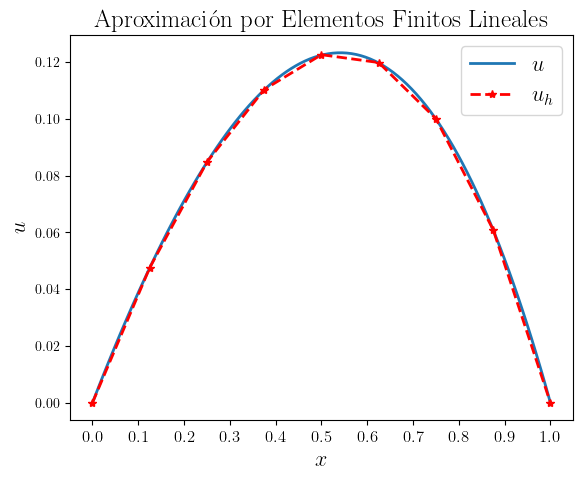

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  2


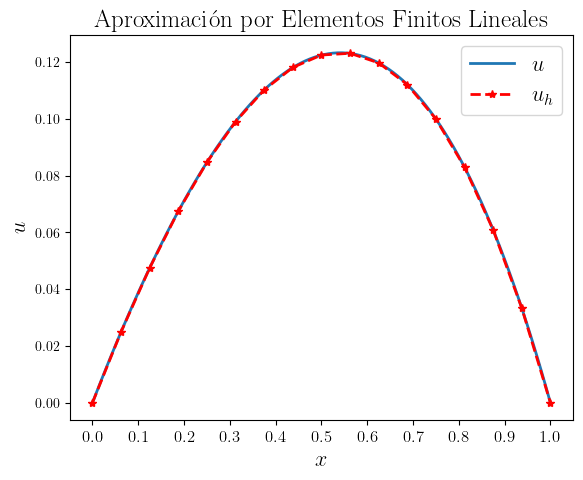

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  3


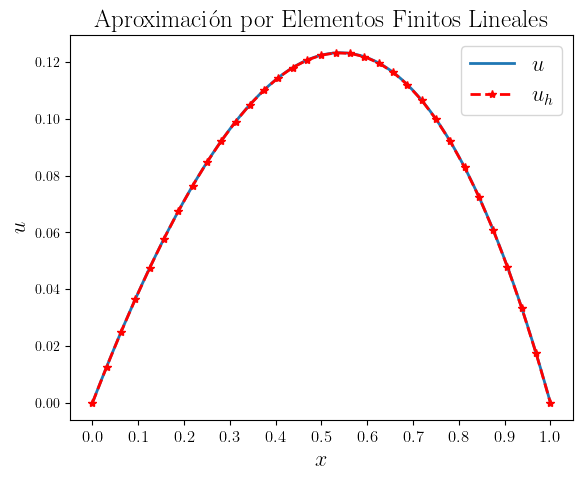

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  6


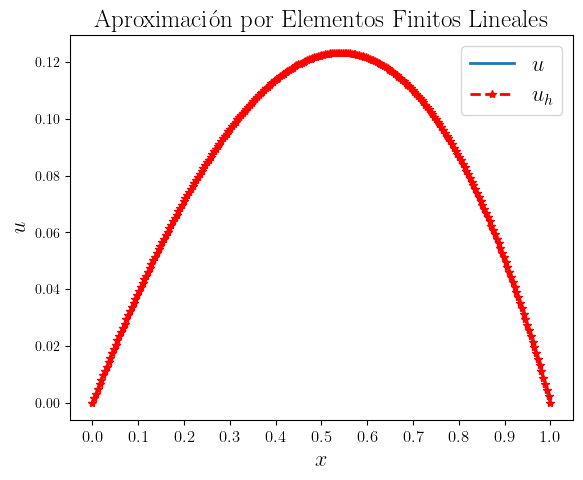


Iteración de refinamiento:  1


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


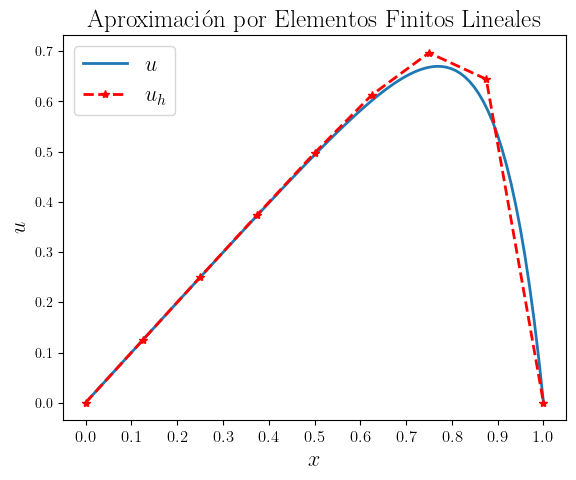

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  2


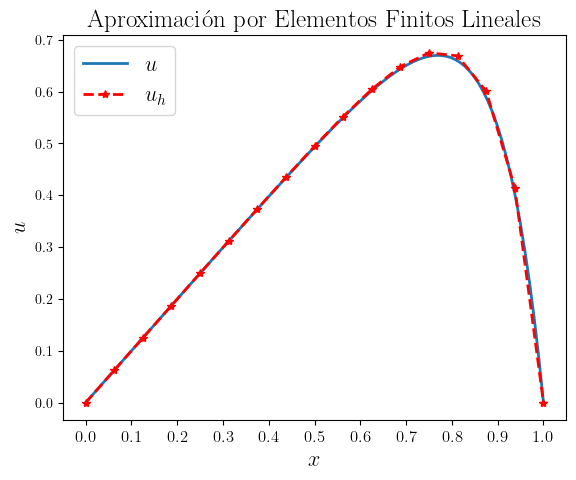

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  3


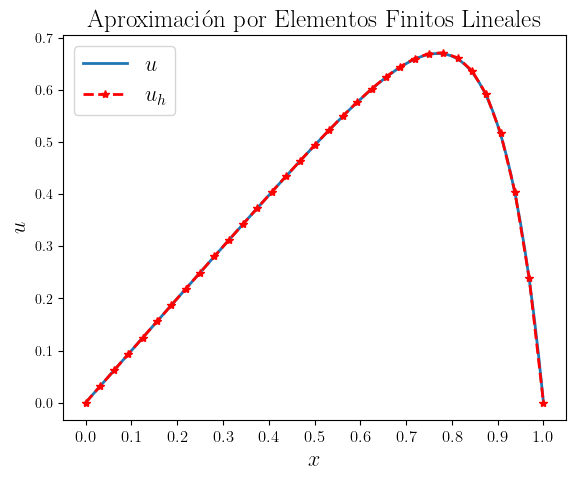

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  6


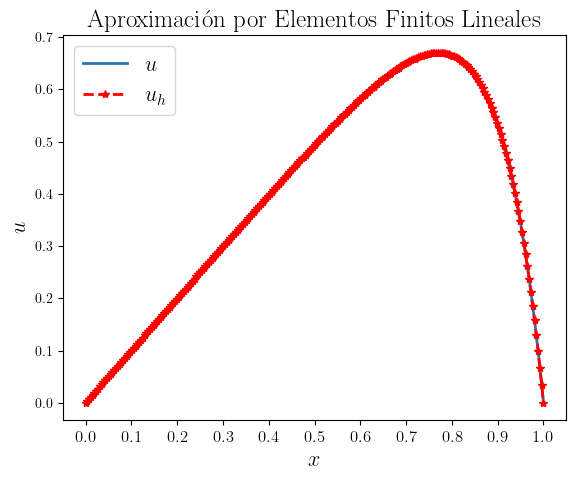


Iteración de refinamiento:  1


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


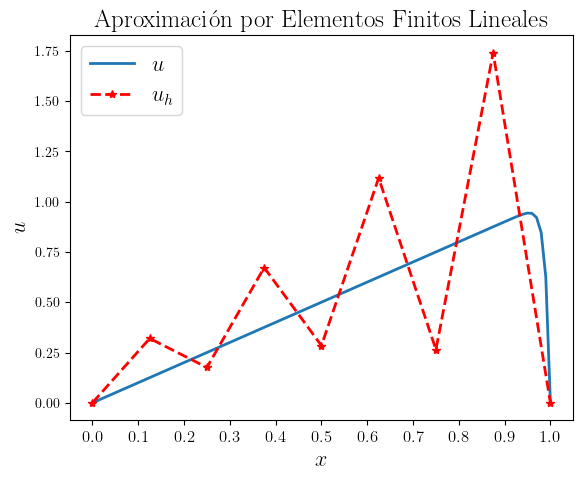

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  2


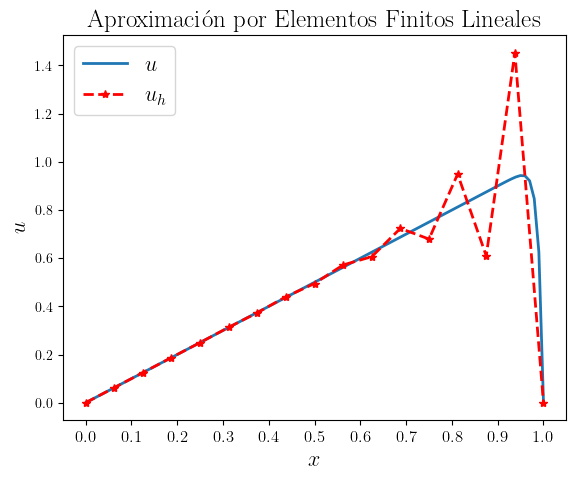

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  3


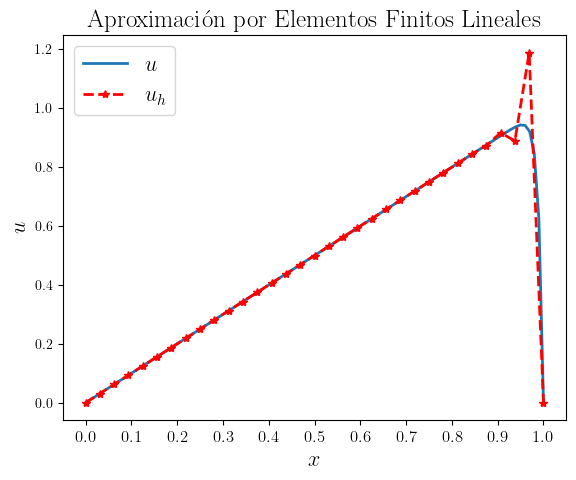

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  6


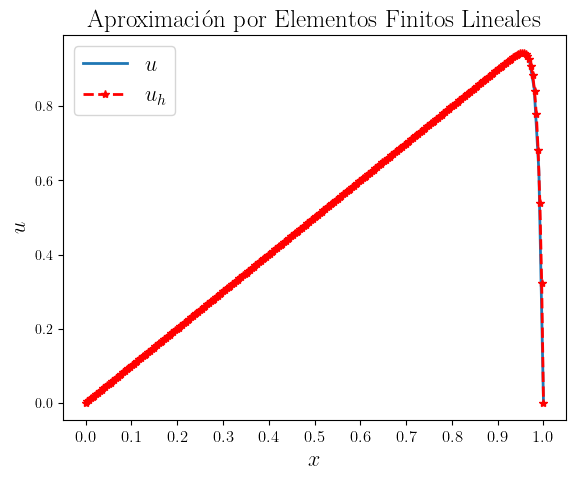

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  1


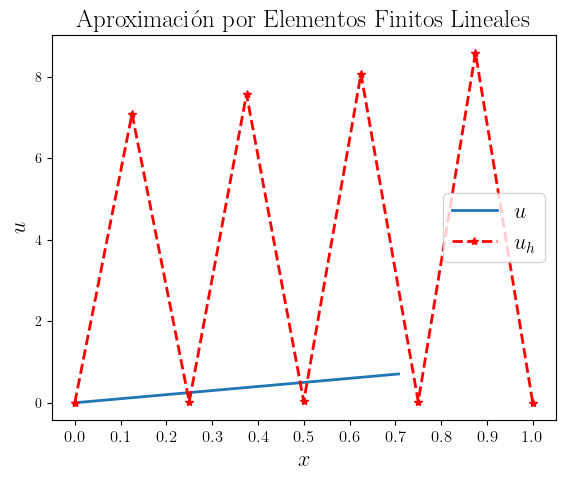

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  2


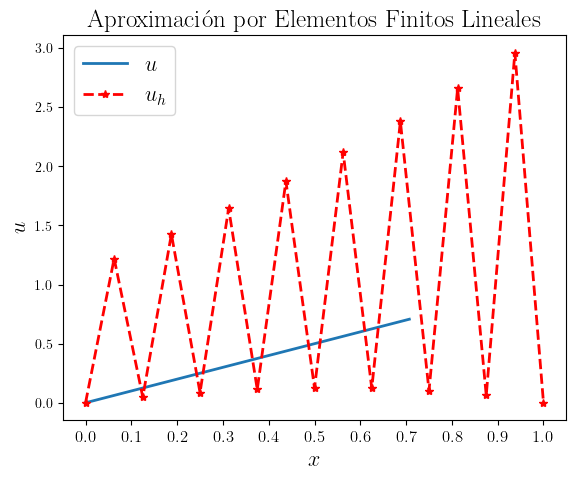

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  3


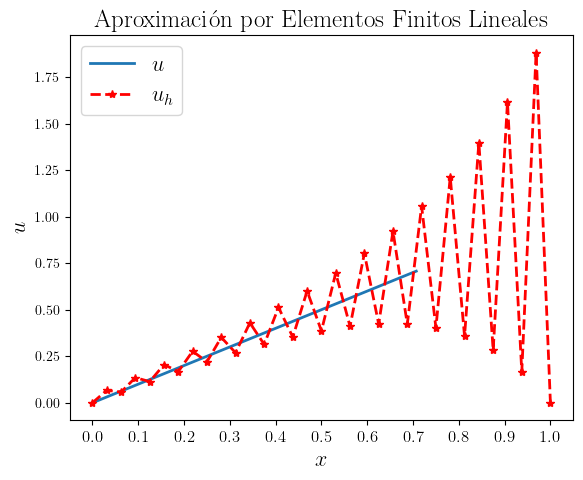

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  6


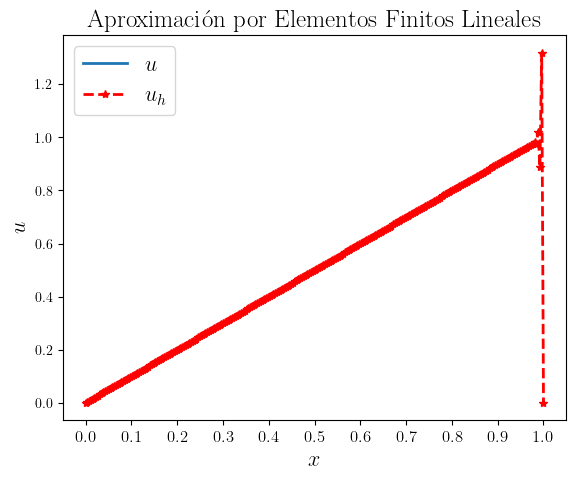

In [4]:
# Se crean diferentes litas que almacenan datos utilices.
ndofs=[[],[],[],[]] # Número de grados de libertad
nnodos=[[],[],[],[]] # Cantidad de nodos
h=[[],[],[],[]] # Tamaños de paso
errorL2=[[],[],[],[]] # Errores en norma L2
errorsH1=[[],[],[],[]] # Errores en semi-norma H1
errorH1=[[],[],[],[]] # Errores en norma H1
RL2=[[],[],[],[]]
RH1=[[],[],[],[]]
 # Contador de iteraciones
beta=1
NU=[1,0.1,0.01,0.001]
flag=True
for i in range(len(NU)):
    count=1
    k=3
    sol_exact = lambda x: (1/beta)*(x-((1-np.exp((beta/NU[i])*x))/(1-np.exp((beta/NU[i])))))
    diff_sol_exact = lambda x: (1/beta)+ ((np.exp((beta/NU[i])*x))/(1-np.exp(beta/NU[i])))
    for n in range(10):
        n=n+3 # n en {1,2,3,4,5,6,7,8,9,10}
        # Mallado
        geo , N = geometry_1D() # Crea la estructura de la geometría
        mesh = ngsolve.Mesh(geo) # Crea el mallado a partir de la geometría
    
        uh,x_vals,fes = solveFEM(mesh,beta,NU[i])
        # Calculo y almacenamiento de datos relevantes
        ndofs[i].append(sum(fes.FreeDofs())) # Cantidad de dofs de la iteración
        nnodos[i].append(mesh.nv) # Cantidad de nodos de la iteración
        h[i].append(1/2**n) # Tamaño de paso utilizado en la iteración
        a,b,c = normas(x_vals,uh,beta,NU[i]) # Cálculo de las normas (locales
        errorL2[i].append("{:.4e}".format(np.sqrt(np.sum(a)))) # Almacena la norma L2 global 
        errorsH1[i].append("{:.4e}".format(np.sqrt(np.sum(b)))) # Almacena la semi-norma H1 global 
        errorH1[i].append("{:.4e}".format(np.sqrt(np.sum(c)))) # Almacena la norma H1 global
    
        # Graficas
        if count==1 or count==2  or count ==3 or count == 6:
            print('\nIteración de refinamiento: ',count)
            xx = np.linspace(0,1,100)
            plt.figure(figsize=(6.5, 5))
            plt.plot(xx, sol_exact(xx), label='$u$',linewidth=2)
            plt.plot(x_vals,uh, '--r*',label='$u_h$',linewidth=2)
            plt.legend()
            plt.legend(fontsize=16)
            plt.title('Aproximación por Elementos Finitos Lineales', fontsize=18)
            plt.xlabel('$x$', fontsize=16)
            plt.ylabel('$u$', fontsize=16)
            custom_xticks = np.arange(0, 1.1, 0.1)
            plt.xticks(custom_xticks, fontsize=12)
            output_file = os.path.join('img/3', 'ru_'+str(NU[i])+'_'+str(count)+'.eps')
            plt.savefig(output_file, format='eps')
            plt.show()
        count=count+1
    rL2,rH1=r_exp(h[i],errorL2[i],errorH1[i])
    RL2[i]=rL2
    RH1[i]=rH1
    k=k-1

nu= 1
   ndofs    norma H1   r_1 (u)    norma L2   r_0 (u)
0      7  3.6689e-02         -  1.3595e-03         -
1     15  1.8570e-02  0.982374  3.4425e-04  1.981548
2     31  9.3361e-03  0.992082  8.6576e-05  1.991418
3     63  4.6801e-03  0.996281  2.1706e-05  1.995873
4    127  2.3430e-03  0.998182  5.4342e-06  1.997954
5    255  1.1722e-03  0.999138  1.3595e-06  1.998992
6    511  5.8629e-04  0.999532  3.3999e-07  1.999512
7   1023  2.9319e-04  0.999779  8.5013e-08  1.999737
8   2047  1.4661e-04  0.999852  2.1255e-08  1.999881
9   4095  7.3306e-05   0.99998  5.3141e-09  1.999905


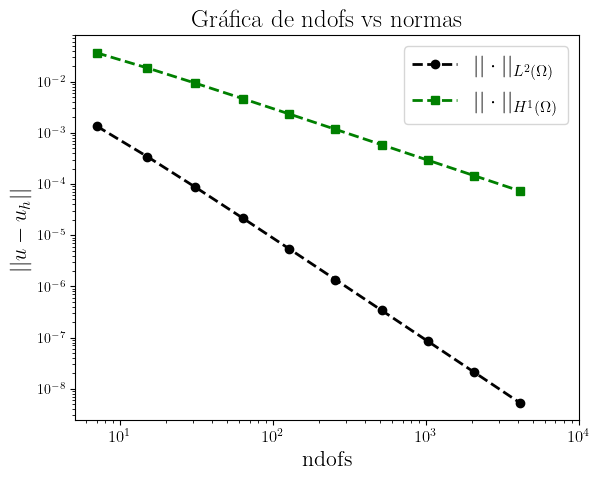

nu= 0.1
   ndofs    norma H1   r_1 (u)    norma L2   r_0 (u)
0      7  2.0274e+00         -  2.3282e-02         -
1     15  2.0165e+00  0.007777  6.0178e-03  1.951907
2     31  2.0136e+00  0.002076  1.5176e-03  1.987445
3     63  2.0128e+00  0.000573  3.8024e-04  1.996809
4    127  2.0126e+00  0.000143  9.5112e-05  1.999211
5    255  2.0126e+00       0.0  2.3781e-05  1.999818
6    511  2.0126e+00       0.0  5.9455e-06  1.999939
7   1023  2.0126e+00       0.0  1.4864e-06  1.999976
8   2047  2.0126e+00       0.0  3.7160e-07       2.0
9   4095  2.0126e+00       0.0  9.2899e-08  2.000016


<Figure size 640x480 with 0 Axes>

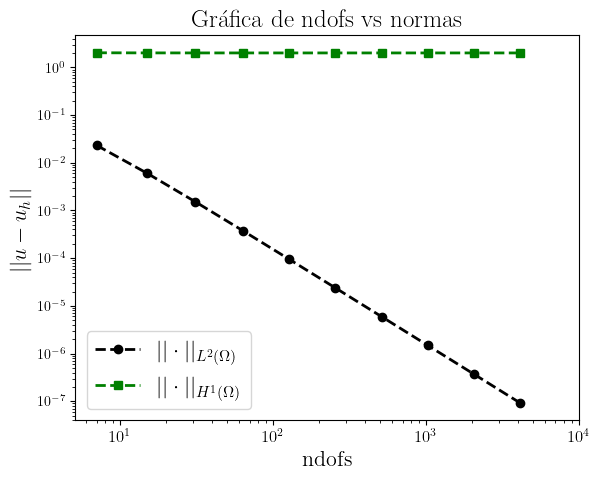

nu= 0.01
   ndofs    norma H1   r_1 (u)    norma L2   r_0 (u)
0      7  7.5931e+00         -  2.7024e-01         -
1     15  7.0381e+00  0.109503  1.0541e-01  1.358229
2     31  7.0191e+00    0.0039  3.8206e-02  1.464141
3     63  7.0067e+00  0.002551  1.1237e-02  1.765542
4    127  7.0021e+00  0.000947  2.9551e-03  1.926978
5    255  7.0008e+00  0.000268  7.4883e-04  1.980497
6    511  7.0005e+00  0.000062  1.8785e-04  1.995057
7   1023  7.0004e+00  0.000021  4.7003e-05  1.998756
8   2047  7.0004e+00       0.0  1.1753e-05  1.999724
9   4095  7.0004e+00       0.0  2.9385e-06  1.999877


<Figure size 640x480 with 0 Axes>

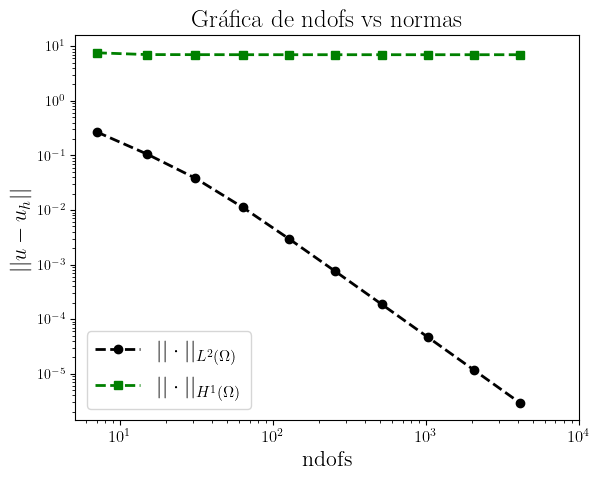

nu= 0.001
   ndofs norma H1 r_1 (u) norma L2  r_0 (u)
0      7      nan       -      nan        -
1     15      nan     NaN      nan      NaN
2     31      nan     NaN      nan      NaN
3     63      nan     NaN      nan      NaN
4    127      nan     NaN      nan      NaN
5    255      nan     NaN      nan      NaN
6    511      nan     NaN      nan      NaN
7   1023      nan     NaN      nan      NaN
8   2047      nan     NaN      nan      NaN
9   4095      nan     NaN      nan      NaN


<Figure size 640x480 with 0 Axes>

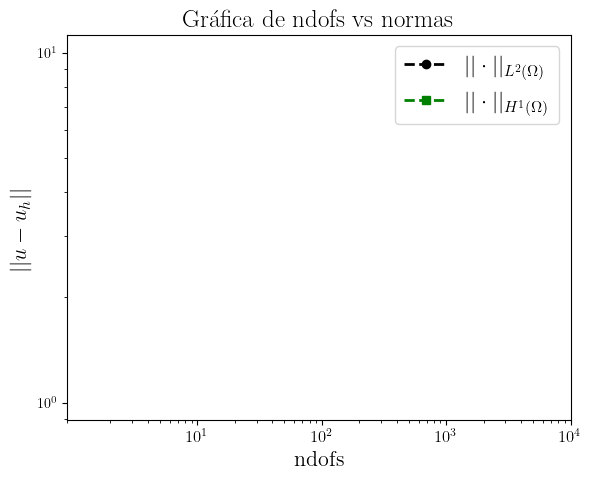

<Figure size 640x480 with 0 Axes>

In [5]:
for i in range(4):   
    print('nu=',NU[i])
    datos={'ndofs': ndofs[i] ,'norma H1': errorH1[i],'r_1 (u)':RH1[i] , 'norma L2': errorL2[i] ,' r_0 (u)':RL2[i]}
    df=pd.DataFrame(datos)
    print(df)
    
    plt.figure(figsize=(6.5, 5))
    plt.loglog(np.transpose(ndofs[i]), np.array(errorL2[i], dtype=float),'--ko', label='$|| \cdot ||_{L^{2} (\Omega)}$',linewidth=2)
    plt.loglog(np.transpose(ndofs[i]), np.array(errorH1[i], dtype=float),'--gs', label='$|| \cdot ||_{H^{1} (\Omega)}$',linewidth=2)
    plt.xlabel('ndofs', fontsize=16)
    plt.ylabel('$|| u - u_h ||$', fontsize=16)
    plt.title('Gráfica de ndofs vs normas',fontsize=18)
    plt.legend()
    plt.legend(fontsize=16)
    custom_xticks = [10**1 , 10**2 ,10**3, 10**4]
    plt.xticks(custom_xticks, fontsize=12)
    plt.show()
    output_file = os.path.join('img/3', 'error_ru_'+str(NU[i])+'.eps')
    plt.savefig(output_file, format='eps')


## Refinamiento Adaptativo

In [6]:
#def etaj(x_vals,uh):
#    eta=[]
#    for i in range(len(x_vals)-2):
#        ff=lambda xx: (1-20*((1/(x_vals[i+2]-x_vals[i+1]))*(uh[i+2]-uh[i+1]))-10*(uh[i]*((x_vals[i+2]-xx)/(x_vals[i+2]-x_vals[i+1])) - uh[i+1]*((xx-x_vals[i+1])/(x_vals[i+2]-x_vals[i+1]))))**2
#        I,e = quad(ff, x_vals[i+1], x_vals[i+2])
#        eta.append((x_vals[i+2]-x_vals[i+1])**2*np.sqrt(I)) 
#    return eta

def etaj(x_vals,uh):
    eta=[]
    beta=1
    for i in range(len(x_vals)-2):
        ff=lambda xx: (1-beta*((1/(x_vals[i+2]-x_vals[i+1]))*(uh[i+2]-uh[i+1])))**2
        I,e = quad(ff, x_vals[i+1], x_vals[i+2])
        eta.append((x_vals[i+2]-x_vals[i+1])**2*np.sqrt(I)) 
    return eta

def mesh_estimate(x_vals,uh):
    eta = etaj(x_vals,uh)
    return np.array(eta, dtype=float), float(max(eta))

def mesh_mark(etalocal,maxerr):
    return [i+1 for i in range(len(x_vals)-2) if etalocal[i] > 0.25 * maxerr]

def mesh_refine(): 
    geometry = Mesh(dim=1)
    mesh_points=x_vals.tolist()
    pnums=[]
    for k in reversed(indice):
        mesh_points.insert(k+1,(mesh_points[k]+mesh_points[k+1])/2)

    for i in mesh_points:
        pnums.append(geometry.Add(MeshPoint(Pnt(i, 0, 0))))

    idx = geometry.AddRegion("material", dim=1)
    for i in range(len(pnums)-1):
        geometry.Add(Element1D([pnums[i],pnums[i+1]], index=idx))
    idx_left = geometry.AddRegion("left", dim=0)
    idx_right = geometry.AddRegion("right", dim=0)

    geometry.Add (Element0D (pnums[0], index=idx_left))
    geometry.Add (Element0D (pnums[len(pnums)-1], index=idx_right))
    return geometry
   

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  1


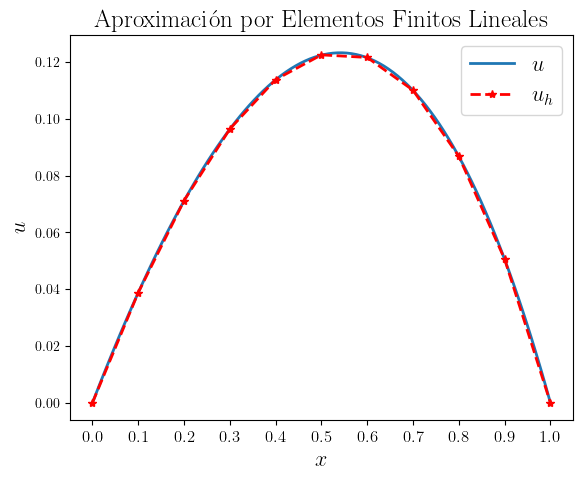

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  2


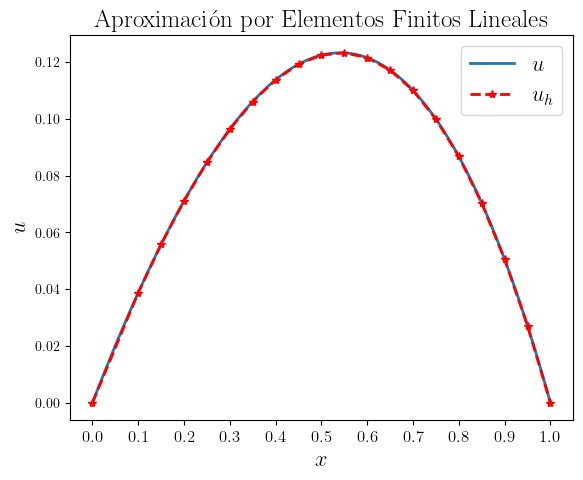

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  3


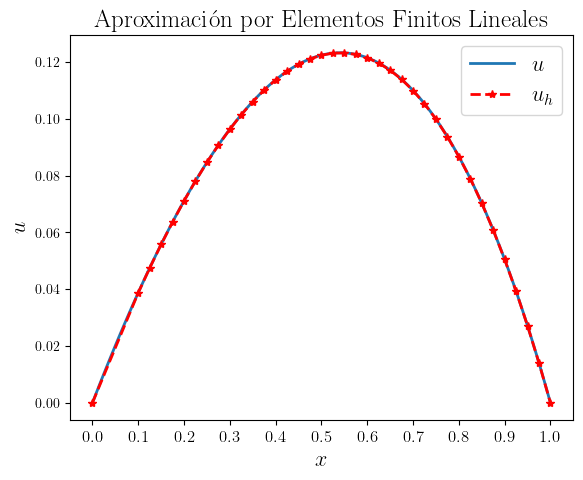

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  4


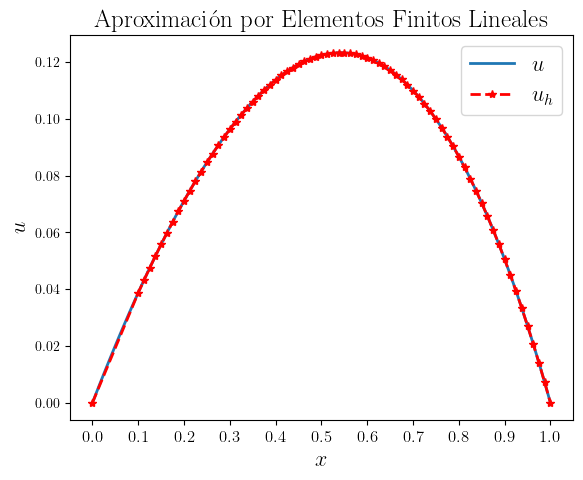

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  1


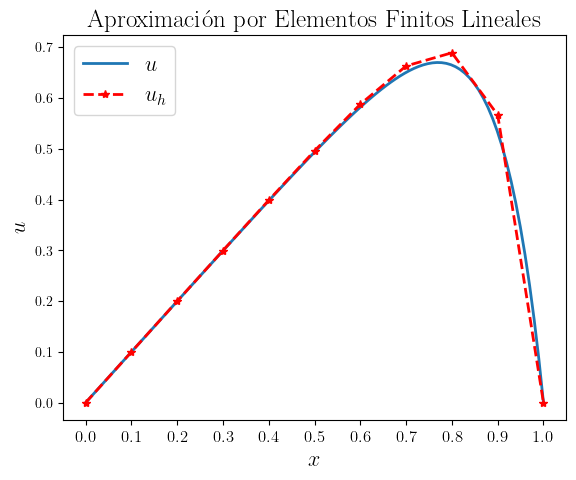

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  2


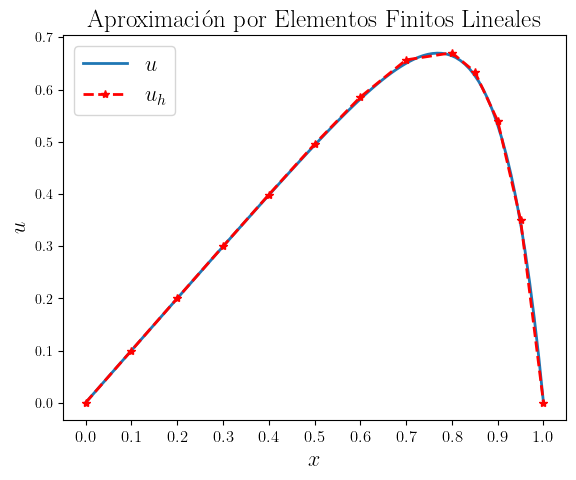

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  3


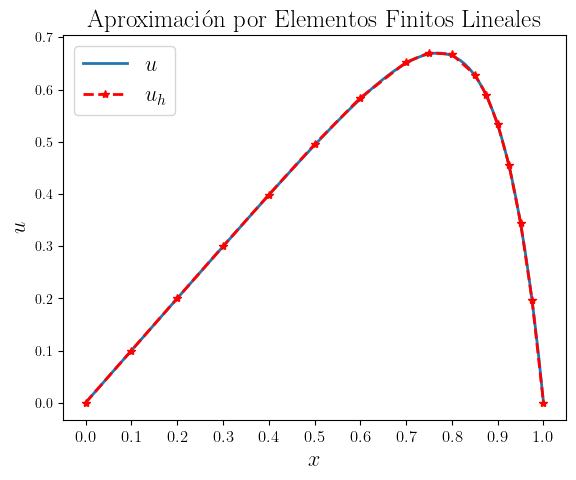

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  4


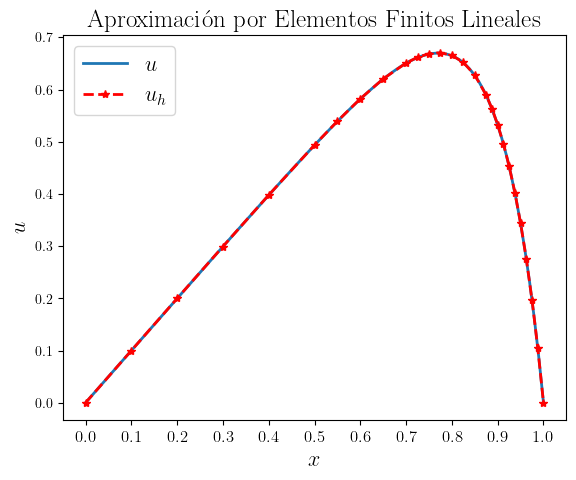

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  1


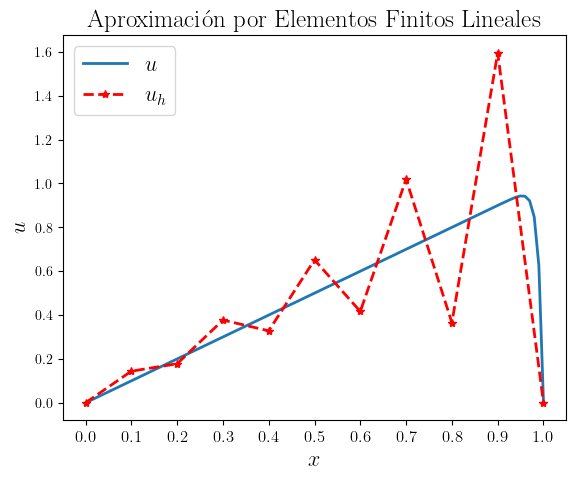

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  2


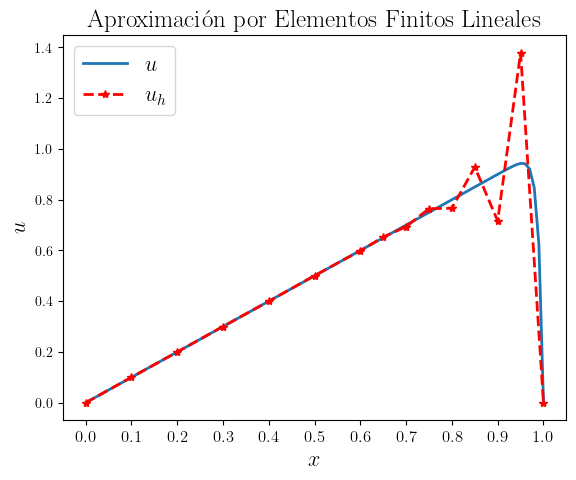

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  3


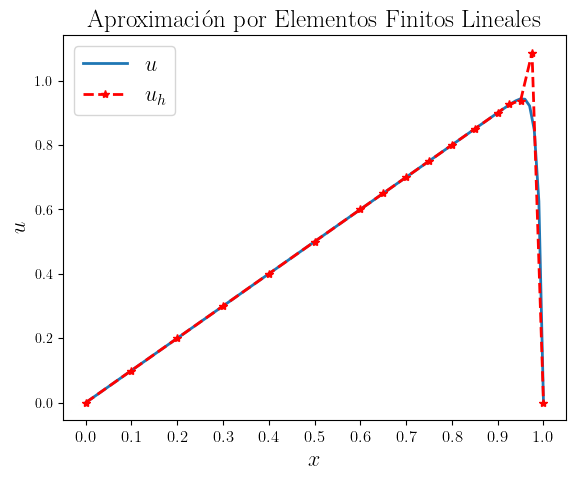

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  4


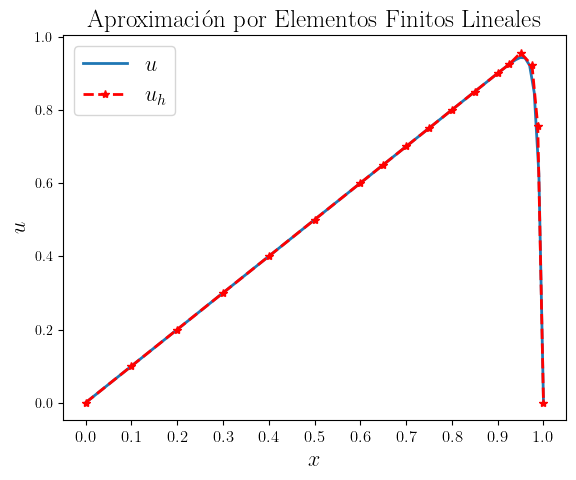

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  1


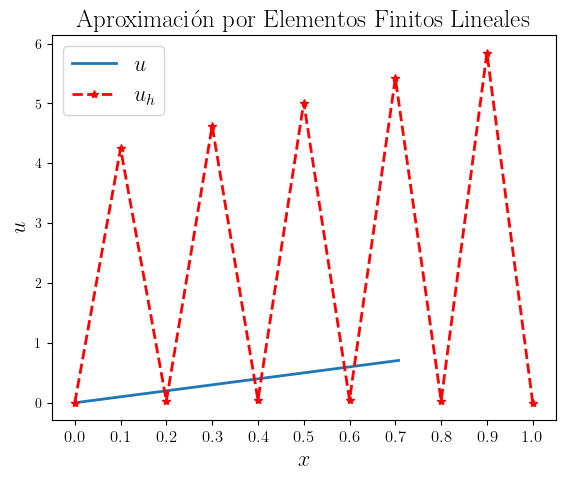

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  2


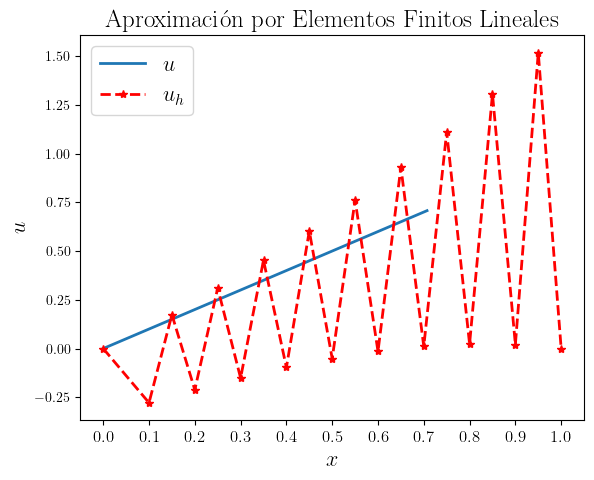

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  3


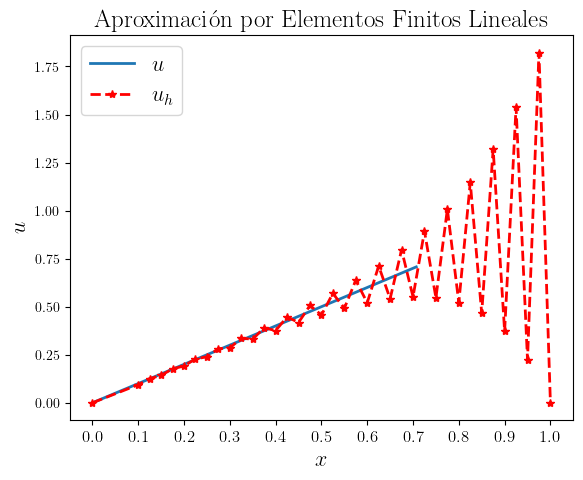

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  4


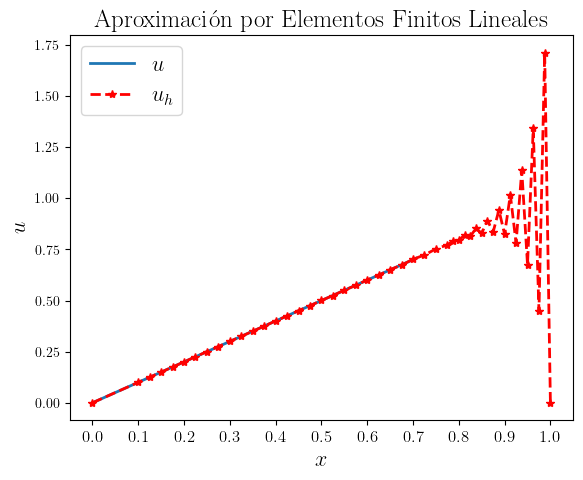

In [7]:
# Se crean diferentes litas que almacenan datos utilices.
ndofs=[[],[],[],[]] # Número de grados de libertad
nnodos=[[],[],[],[]] # Cantidad de nodos
h=[[],[],[],[]] # Tamaños de paso
errorL2=[[],[],[],[]] # Errores en norma L2
errorsH1=[[],[],[],[]] # Errores en semi-norma H1
errorH1=[[],[],[],[]] # Errores en norma H1
RL2=[[],[],[],[]]
RH1=[[],[],[],[]]
ETA=[[],[],[],[]]
 # Contador de iteraciones
beta=1
NU=[1,0.1,0.01,0.001]
tol=10**(-4)
flag=False
for j in range(len(NU)):
    count=1
    k=3
    sol_exact = lambda x: (1/beta)*(x-((1-np.exp((beta/NU[j])*x))/(1-np.exp((beta/NU[j])))))
    diff_sol_exact = lambda x: (1/beta)+ ((np.exp((beta/NU[j])*x))/(1-np.exp(beta/NU[j])))
    
    geometry = Mesh(dim=1)
    h0=1/10
    N=10
    pnums = []
    for i in range(0, N+1):
        pnums.append (geometry.Add (MeshPoint (Pnt(i*h0, 0, 0))))
    idx = geometry.AddRegion("material", dim=1)
    for i in range(0,N):
        geometry.Add (Element1D ([pnums[i],pnums[i+1]], index=idx))
    idx_left = geometry.AddRegion("left", dim=0)
    idx_right = geometry.AddRegion("right", dim=0)

    geometry.Add (Element0D (pnums[0], index=idx_left))
    geometry.Add (Element0D (pnums[N], index=idx_right))
    mesh = ngsolve.Mesh(geometry) # Crea el mallado a partir de la geometría'

    while count < 11:
        # Mallado
        uh,x_vals,fes = solveFEM(mesh,beta,NU[j])
    
        # Graficas
        if count==1 or count==2  or count ==3 or count == 4:
            print('\nIteración de refinamiento: ',count)
            xx = np.linspace(0,1,100)
            plt.figure(figsize=(6.5, 5))
            plt.plot(xx, sol_exact(xx), label='$u$',linewidth=2)
            plt.plot(x_vals,uh, '--r*',label='$u_h$',linewidth=2)
            plt.legend()
            plt.legend(fontsize=16)
            plt.title('Aproximación por Elementos Finitos Lineales', fontsize=18)
            plt.xlabel('$x$', fontsize=16)
            plt.ylabel('$u$', fontsize=16)
            custom_xticks = np.arange(0, 1.1, 0.1)
            plt.xticks(custom_xticks, fontsize=12)
            output_file = os.path.join('img/3', 'ra_'+str(NU[j])+'_'+str(count)+'.eps')
            plt.savefig(output_file, format='eps')
            plt.show()
        
        etalocal,maxerr = mesh_estimate(x_vals,uh)
        indice = [i+1 for i in range(len(x_vals)-2) if etalocal[i] > 0.25 * maxerr]
        
        # Calculo y almacenamiento de datos relevantes
        ndofs[j].append(sum(fes.FreeDofs())) # Cantidad de dofs de la iteración
        nnodos[j].append(mesh.nv) # Cantidad de nodos de la iteración
        a,b,c = normas(x_vals,uh,beta,NU[j]) # Cálculo de las normas (locales
        errorL2[j].append("{:.4e}".format(np.sqrt(np.sum(a)))) # Almacena la norma L2 global 
        errorsH1[j].append("{:.4e}".format(np.sqrt(np.sum(b)))) # Almacena la semi-norma H1 global 
        errorH1[j].append("{:.4e}".format(np.sqrt(np.sum(c)))) # Almacena la norma H1 global
        ETA[j].append("{:.4e}".format(np.sqrt(np.sum(etalocal**2))))
        
        if np.sqrt(np.sum(etalocal**2)) <= tol:
            break
        
        count=count+1
        geometry = mesh_refine()
        mesh = ngsolve.Mesh(geometry)
    rL2,rH1=r_exp([1/x for x in nnodos[j]],errorL2[j],errorH1[j])
    RL2[j]=rL2
    RH1[j]=rH1
    k=k-1

nu= 1


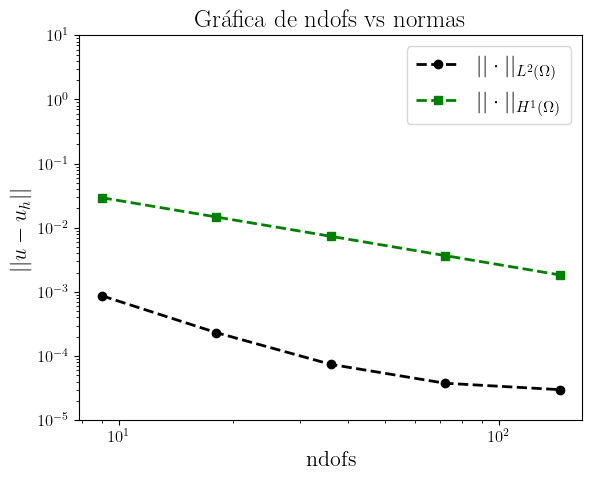

nu= 0.1


<Figure size 640x480 with 0 Axes>

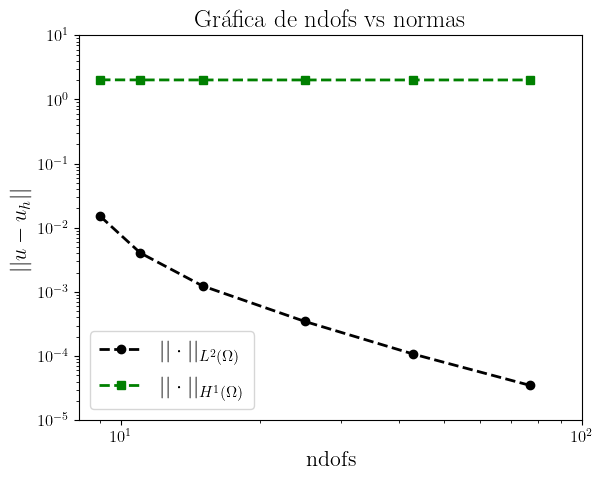

nu= 0.01


<Figure size 640x480 with 0 Axes>

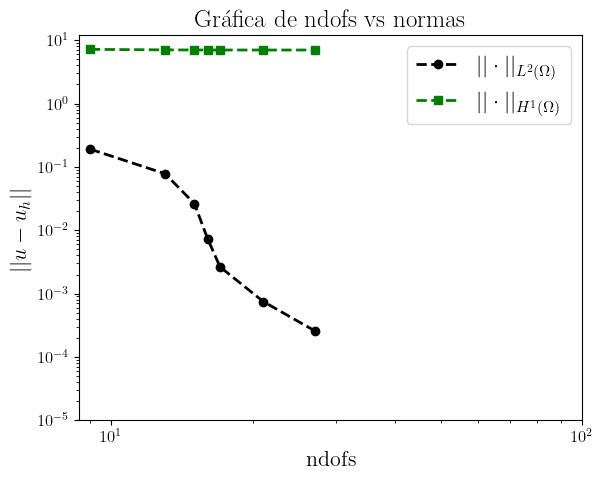

<Figure size 640x480 with 0 Axes>

In [8]:
for i in range(3):
    print('nu=',NU[i])
    datos={'ndofs': ndofs[i] ,'norma H1': errorH1[i],'r_1 (u)':RH1[i] , 'norma L2': errorL2[i] ,' r_0 (u)':RL2[i] , 'eta': ETA[i]}
    df=pd.DataFrame(datos)
    
    plt.figure(figsize=(6.5, 5))
    plt.loglog(np.transpose(ndofs[i]), np.array(errorL2[i], dtype=float),'--ko', label='$|| \cdot ||_{L^{2} (\Omega)}$',linewidth=2)
    plt.loglog(np.transpose(ndofs[i]), np.array(errorH1[i], dtype=float),'--gs', label='$|| \cdot ||_{H^{1} (\Omega)}$',linewidth=2)
    plt.xlabel('ndofs', fontsize=16)
    plt.ylabel('$|| u - u_h ||$', fontsize=16)
    plt.title('Gráfica de ndofs vs normas',fontsize=18)
    plt.legend()
    plt.legend(fontsize=16)
    custom_xticks = [10**1 , 10**2 ]
    plt.xticks(custom_xticks, fontsize=12)
    custom_yticks = [10**-5 ,10**-4 ,10**-3,10**-2,10**-1,10**0, 10**1 ]
    plt.yticks(custom_yticks, fontsize=12)
    plt.show()
    output_file = os.path.join('img/3', 'error_ra_'+str(NU[i])+'.eps')
    plt.savefig(output_file, format='eps')

nu= 1


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


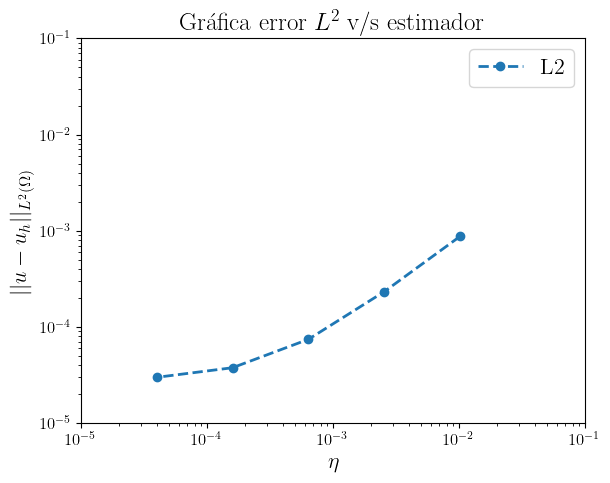

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


nu= 0.1


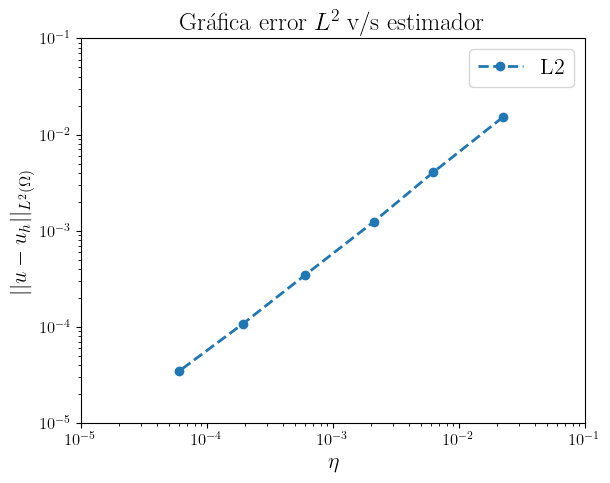

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


nu= 0.01


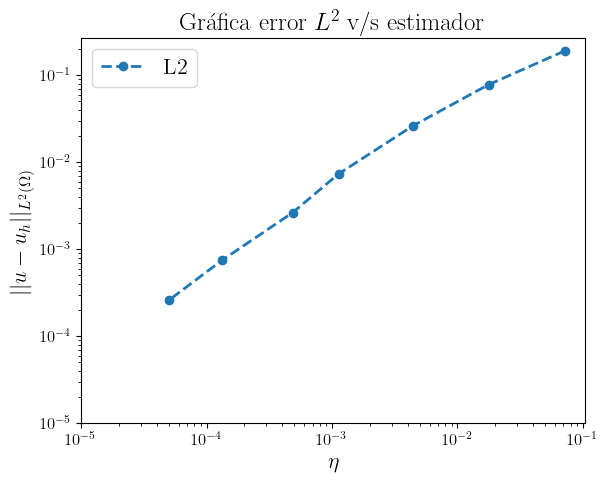

In [9]:
for i in range(3):
    print('nu=',NU[i])
    plt.figure(figsize=(6.5, 5))
    plt.loglog(np.array(ETA[i], dtype=float),np.array(errorL2[i], dtype=float),'--o', label='L2',linewidth=2)
    plt.ylabel('$|| u - u_h ||_{L^{2} (\Omega)}$',fontsize=16)
    plt.xlabel('$\eta$',fontsize=16)
    plt.title(' Gráfica error $L^2$ v/s estimador',fontsize=18)
    plt.legend()
    plt.legend(fontsize=16)
    custom_xticks = [10**-5,10**-4 , 10**-3 , 10**-2 , 10**-1]
    plt.xticks(custom_xticks, fontsize=12)
    custom_yticks = [10**-5,10**-4 , 10**-3 , 10**-2 ,10**-1]
    plt.yticks(custom_yticks, fontsize=12)
    output_file = os.path.join('img/3', 'estimador_'+str(NU[i])+'.eps')
    plt.savefig(output_file, format='eps')
    plt.show()
